# Getting Started with Emission Spectroscopy

Last update: January 26th (2025) Hajime Kawahara for v2.0

In this getting started guide, we will use ExoJAX to simulate a high-resolution emission spectrum from an atmosphere with CO molecular absorption and hydrogen molecule CIA continuum absorption as the opacity sources. We will then add appropriate noise to the simulated spectrum to create a mock spectrum and perform spectral retrieval using NumPyro's HMC NUTS. 

The author wrote this Jupyter notebook on a gaming laptop equipped with an RTX 3080 GPU, so it is recommended to use a machine with similar or higher GPU specifications. However, except for the HMC NUTS part, the code should also work on lower-spec systems. Now, let’s get started!

First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [4]:
from jax import config
config.update("jax_enable_x64", True)

The following schematic figure explains how ExoJAX works; 
(1) loading databases (`*db`), 
(2) calculating opacity (`opa`),
(3) running atmospheric radiative transfer (`art`),
(4) applying operations on the spectrum (`sop`)

In this "getting started" guide, there are two opacity sources, CO and CIA. Their respective databases, `mdb` and `cdb`, are converted by `opa` into the opacity of each atmospheric layer, which is then used in the radiative transfer calculation performed by `art`. Finally, `sop` convolves the rotational effects and instrumental profiles, generating the emission spectrum. 

`mdb`/`cdb` --> `opa` --> `art` --> `sop` ---> spectrum

This spectral model is incorporated into the probabilistic model in NumPyro, and retrieval is performed by sampling using HMC-NUTS.




![Figure. Structure of ExoJAX](https://secondearths.sakura.ne.jp/exojax/figures/exojax_get_started.png)


## 1. Loading a molecular database using mdb

ExoJAX has an API for molecular databases, called `mdb` (or `adb` for atomic datbases). Prior to loading the database, define the wavenumber range first.

In [5]:
from exojax.utils.grids import wavenumber_grid

nu_grid, wav, resolution = wavenumber_grid(
    22920.0, 23000.0, 3500, unit="AA", xsmode="premodit"
)
print("Resolution=", resolution)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
Resolution= 1004211.9840291934


/home/kawahara/exojax/src/exojax/utils.grids.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(


Then, let's load the molecular database. We here use Carbon monoxide in Exomol. `CO/12C-16O/Li2015` means `Carbon monoxide/ isotopes = 12C + 16O / database name`. You can check the database name in the ExoMol website (https://www.exomol.com/).  

In [6]:
from exojax.database.api  import MdbExomol
mdb = MdbExomol(".database/CO/12C-16O/Li2015", nurange=nu_grid)

/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


HITRAN exact name= (12C)(16O)
radis engine =  vaex
Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.15.2-py3.10.egg/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(


## 2. Computation of the Cross Section using opa

ExoJAX has various opacity calculator classes, so-called `opa`. Here, we use a memory-saved opa, `OpaPremodit`. We assume the robust tempreature range we will use is 500-1500K.

In [8]:
from exojax.opacity import OpaPremodit
opa = OpaPremodit(mdb, nu_grid, auto_trange=[500.0, 1500.0], dit_grid_resolution=1.0)

/home/kawahara/exojax/src/exojax/spec/opacalc.py:215: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]

Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%


Then let's compute cross section for two different temperature 500 and 1500 K for P=1.0 bar. opa.xsvector can do that!

In [9]:
P = 1.0  # bar
T_1 = 500.0  # K
xsv_1 = opa.xsvector(T_1, P)  # cm2

T_2 = 1500.0  # K
xsv_2 = opa.xsvector(T_2, P)  # cm2

Plot them. It can be seen that different lines are stronger at different temperatures.

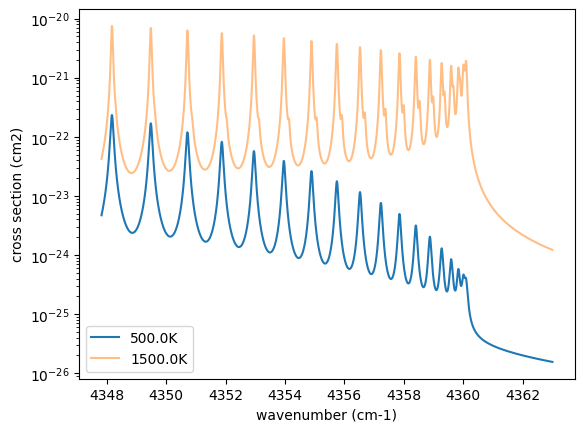

In [10]:
import matplotlib.pyplot as plt

plt.plot(nu_grid, xsv_1, label=str(T_1) + "K")  # cm2
plt.plot(nu_grid, xsv_2, alpha=0.5, label=str(T_2) + "K")  # cm2
plt.yscale("log")
plt.legend()
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

## 3. Atmospheric Radiative Transfer

ExoJAX can solve the radiative transfer and derive the emission spectrum. To do so, ExoJAX has `art` class. `ArtEmisPure` means Atomospheric Radiative Transfer for Emission with Pure absorption. So, `ArtEmisPure` does not include scattering.
We set the number of the atmospheric layer to 200 (nlayer) and the pressure at bottom and top atmosphere to 100 and 1.e-5 bar.

Since v1.5, one can choose the rtsolver (radiative transfer solver) from the flux-based 2 stream solver (`fbase2st`) and the intensity-based n-stream sovler (`ibased`). Use `rtsolver` option. In the latter case, the number of the stream (`nstream`) can be specified. Note that the default rtsolver for the pure absorption (i.e. no scattering nor reflection) has been `ibased` since v1.5.
In our experience, `ibased` is faster and more accurate than `fbased`.

In [11]:
from exojax.rt import ArtEmisPure

art = ArtEmisPure(
    nu_grid=nu_grid,
    pressure_btm=1.0e1,
    pressure_top=1.0e-5,
    nlayer=100,
    rtsolver="ibased",
    nstream=8,
)

rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


Let's assume the power law temperature model, within 500 - 1500 K.

$T = T_0 P^\alpha$

where $T_0=1200$ K and $\alpha=0.1$.

In [12]:
art.change_temperature_range(500.0, 1500.0)
Tarr = art.powerlaw_temperature(1200.0, 0.1)

Also, the mass mixing ratio of CO (MMR) should be defined.

In [13]:
mmr_profile = art.constant_mmr_profile(0.01)

Surface gravity is also important quantity of the atmospheric model, which is a function of planetary radius and mass. Here we assume 1 RJ and 10 MJ.

In [14]:
from exojax.utils.astrofunc import gravity_jupiter

gravity = gravity_jupiter(1.0, 10.0)

In addition to the CO cross section, we would consider [collisional induced absorption](https://en.wikipedia.org/wiki/Collision-induced_absorption_and_emission) (CIA) as a continuum opacity. `cdb` class can be used.

In [15]:
from exojax.database.contdb  import CdbCIA
from exojax.opacity import OpaCIA

cdb = CdbCIA(".database/H2-H2_2011.cia", nurange=nu_grid)
opacia = OpaCIA(cdb, nu_grid=nu_grid)

H2-H2


Before running the radiative transfer, we need cross sections for layers, called `xsmatrix` for CO and `logacia_matrix` for CIA (strictly speaking, the latter is not cross section but coefficient because CIA intensity is proportional density square). See [here](CIA_opacity.html) for the details.

In [16]:
xsmatrix = opa.xsmatrix(Tarr, art.pressure)
logacia_matrix = opacia.logacia_matrix(Tarr)

Convert them to opacity

In [17]:
dtau_CO = art.opacity_profile_xs(xsmatrix, mmr_profile, mdb.molmass, gravity)
vmrH2 = 0.855  # VMR of H2
mmw = 2.33  # mean molecular weight of the atmosphere
dtaucia = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2, mmw, gravity)

Add two opacities.

In [18]:
dtau = dtau_CO + dtaucia

Then, run the radiative transfer.
As you can see, the emission spectrum has been generated. This spectrum shows a region near 4360 cm-1, or around 22940 AA, where CO features become increasingly dense. This region is referred to as the band head. If you're interested in why the band head occurs, please refer to [Quatum states of Carbon Monoxide and Fortrat Diagram](Fortrat.html).


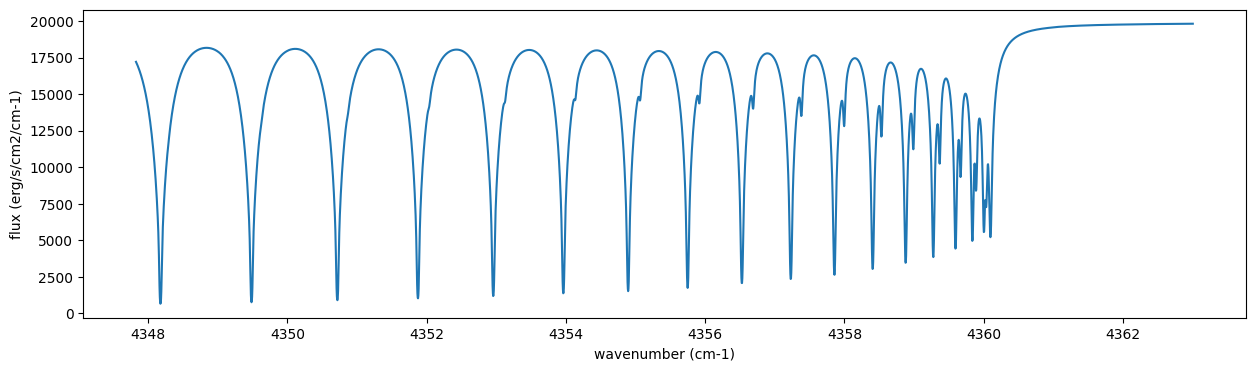

In [19]:
F = art.run(dtau, Tarr)

fig = plt.figure(figsize=(15, 4))
plt.plot(nu_grid, F)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.show()

You can check the contribution function too! 
You should check if the dominant contribution is within the layer. 
If not, you need to change `pressure_top` and `pressure_btm` in `ArtEmisPure`    

In [20]:
from exojax.plot.atmplot import plotcf

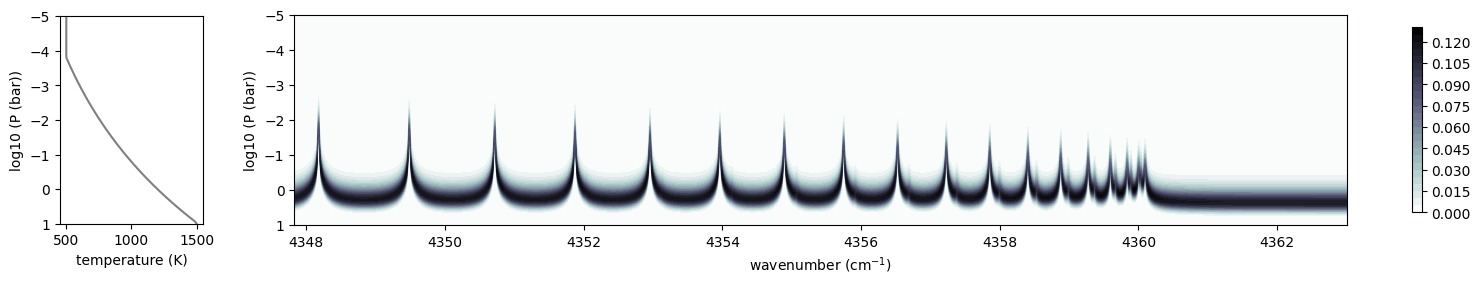

In [21]:
cf = plotcf(nu_grid, dtau, Tarr, art.pressure, art.dParr)

## 4. Spectral Operators: rotational broadening, instrumental profile, Doppler velocity shift and so on, any operation on spectra.

The above spectrum is called "raw spectrum" in ExoJAX. The effects applied to the raw spectrum is handled in ExoJAX by the spectral operator (`sop`).
First, we apply the spin rotational broadening of a planet.

In [24]:
from exojax.postproc.specop import SopRotation

sop_rot = SopRotation(nu_grid, vsini_max=100.0)

vsini = 10.0
u1 = 0.0
u2 = 0.0
Frot = sop_rot.rigid_rotation(F, vsini, u1, u2)

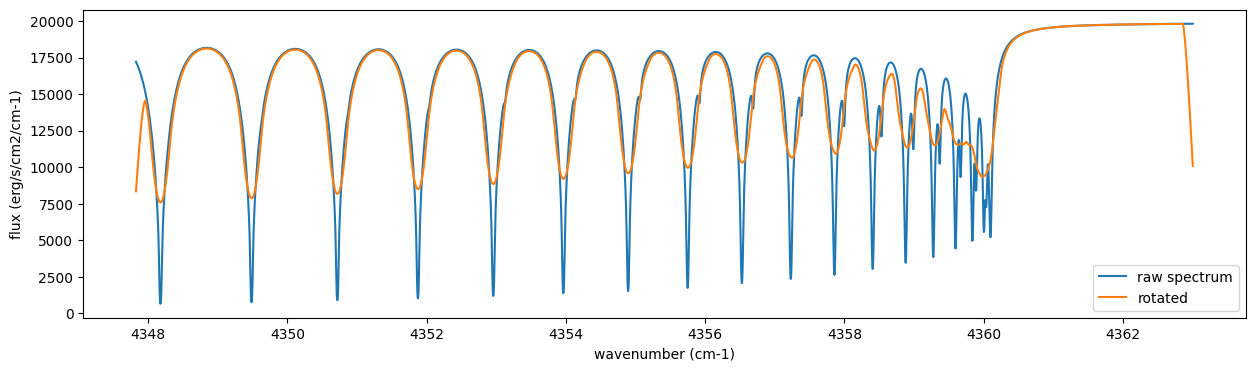

In [25]:
fig = plt.figure(figsize=(15, 4))
plt.plot(nu_grid, F, label="raw spectrum")
plt.plot(nu_grid, Frot, label="rotated")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.legend()
plt.show()

Then, the instrumental profile with relative radial velocity shift is applied. Also, we need to match the computed spectrum to the data grid. This process is called `sampling` (but just interpolation though). Below, let’s perform a simulation that includes noise for use in later analysis.

In [52]:
from exojax.postproc.specop import SopInstProfile
from exojax.utils.instfunc import resolution_to_gaussian_std

sop_inst = SopInstProfile(nu_grid, vrmax=1000.0)

RV = 40.0  # km/s
resolution_inst =70000.0
beta_inst = resolution_to_gaussian_std(resolution_inst)
Finst = sop_inst.ipgauss(Frot, beta_inst)
nu_obs = nu_grid[::5][:-50]


from numpy.random import normal
noise = 500.0
Fobs = sop_inst.sampling(Finst, RV, nu_obs) + normal(0.0, noise, len(nu_obs))

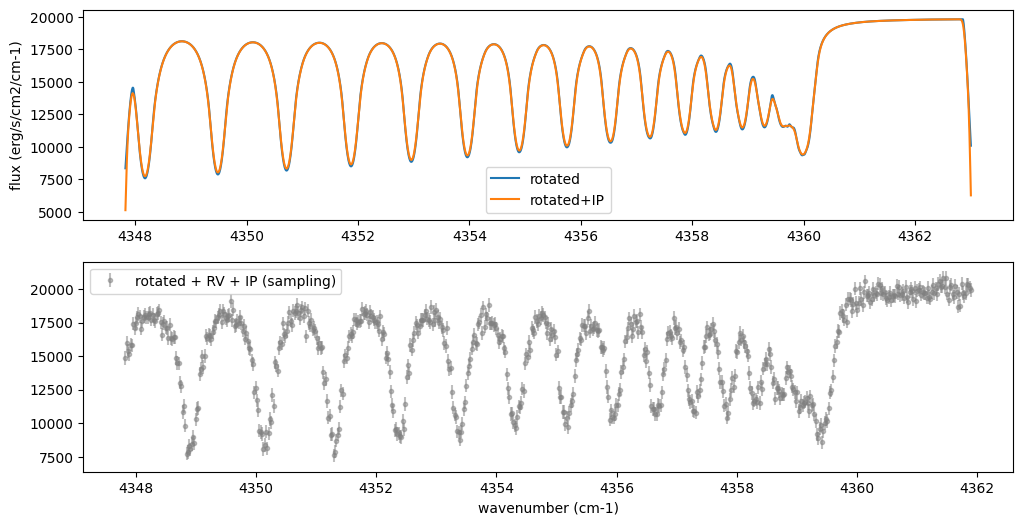

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
plt.plot(nu_grid, Frot, label="rotated")
plt.plot(nu_grid, Finst, label="rotated+IP")
plt.ylabel("flux (erg/s/cm2/cm-1)")
plt.legend()
ax = fig.add_subplot(212)
plt.errorbar(nu_obs, Fobs, noise, fmt=".", label="rotated + RV + IP (sampling)", color="gray",alpha=0.5)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.show()

## 5. Retrieval of an Emission Spectrum

Next, let’s perform a “retrieval” on the simulated spectrum created above. Retrieval involves estimating the parameters of an atmospheric model in the form of a posterior distribution based on the spectrum. To do this, we first need a model. Here, we have compiled the forward modeling steps so far and defined the model as follows. The spectral model has six parameters.

In [71]:
def fspec(T0, alpha, mmr, g, RV, vsini):
    #molecule
    Tarr = art.powerlaw_temperature(T0, alpha)
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(mmr)
    dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opacia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtau + dtaucH2H2
    F = art.run(dtau, Tarr)
    Frot = sop_rot.rigid_rotation(F, vsini, u1, u2)
    Finst = sop_inst.ipgauss(Frot, beta_inst)
    mu = sop_inst.sampling(Finst, RV, nu_obs)
    return mu

Let’s verify that spectra are being generated from `fspec` with various parameter sets.

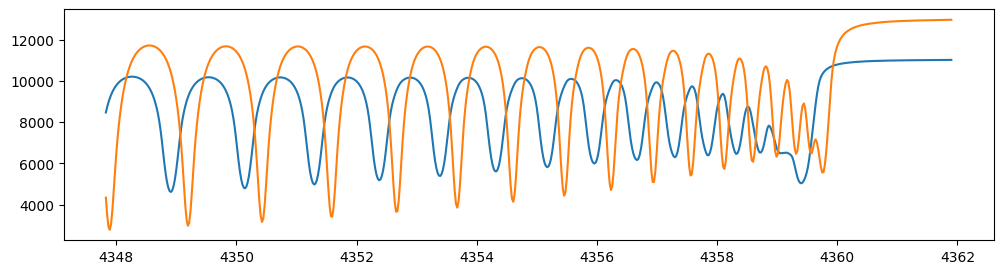

In [ ]:
fig = plt.figure(figsize=(12, 3))

plt.plot(nu_obs, fspec(1200.0, 0.09, 0.01, gravity_jupiter(1.0, 1.0), 40.0, 10.0),label="model")
plt.plot(nu_obs, fspec(1100.0, 0.12, 0.01, gravity_jupiter(1.0, 10.0), 20.0, 5.0),label="model")

NumPyro is a probabilistic programming language (PPL), which requires the definition of a probabilistic model. In the probabilistic model `model_prob` defined below, the prior distributions of each parameter are specified. The previously defined spectral model is used within this probabilistic model as a function that provides the mean $\mu$. The spectrum is assumed to be generated according to a Gaussian distribution with this mean and a standard deviation $\sigma$. i.e. $f(\nu_i) \sim \mathcal{N}(\mu(\nu_i; {\bf p}), \sigma^2 I)$, where ${\bf p}$ is the spectral model parameter set, which are the arguments of `fspec`. 



In [73]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import numpyro
from jax import random

In [79]:
def model_prob(spectrum):

    #atmospheric/spectral model parameters priors
    logg = numpyro.sample('logg', dist.Uniform(4.0, 5.0))
    RV = numpyro.sample('RV', dist.Uniform(35.0, 45.0))
    mmr = numpyro.sample('MMR', dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(5.0, 15.0))
    mu = fspec(T0, alpha, mmr, 10**logg, RV, vsini)

    #noise model parameters priors
    sigmain = numpyro.sample('sigmain', dist.Exponential(1.e-3)) 

    numpyro.sample('spectrum', dist.Normal(mu, sigmain), obs=spectrum)

Note that we did not account for the effects of limb darkening. However, in actual analyses, one possible approach might be to use an uninformative prior, such as the one proposed by Kipping.

```python
    from exojax.postproc.limb_darkening import ld_kipping
    q1 = numpyro.sample('q1', dist.Uniform(0.0,1.0))
    q2 = numpyro.sample('q2', dist.Uniform(0.0,1.0))
    u1,u2 = ld_kipping(q1,q2)
```

Now, let’s define NUTS and start sampling. 

In [68]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_prob, forward_mode_differentiation=True)
kernel = NUTS(model_prob, forward_mode_differentiation=False)

Since this process will take several hours, feel free to go for a long lunch break!

In [75]:
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, spectrum=Fobs)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [3:32:24<00:00,  8.50s/it, 255 steps of size 2.63e-02. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       MMR      0.01      0.00      0.01      0.01      0.01    301.05      1.00
        RV     39.95      0.06     39.95     39.84     40.05    675.86      1.00
        T0   1196.47      6.93   1196.30   1183.85   1206.73    400.13      1.00
     alpha      0.10      0.00      0.10      0.09      0.10    335.22      1.00
      logg      4.45      0.06      4.45      4.37      4.56    354.23      1.00
   sigmain    472.25     13.78    471.80    451.90    495.79    837.97      1.00
     vsini      9.79      0.17      9.79      9.54     10.10    351.43      1.00

Number of divergences: 0


After returning from your long lunch, if you're lucky and the sampling is complete, let’s write a predictive model for the spectrum.

In [99]:
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
import jax.numpy as jnp

In [81]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_prob, posterior_sample, return_sites=['spectrum'])
predictions = pred(rng_key_, spectrum=None)
median_mu1 = jnp.median(predictions['spectrum'], axis=0)
hpdi_mu1 = hpdi(predictions['spectrum'], 0.9)

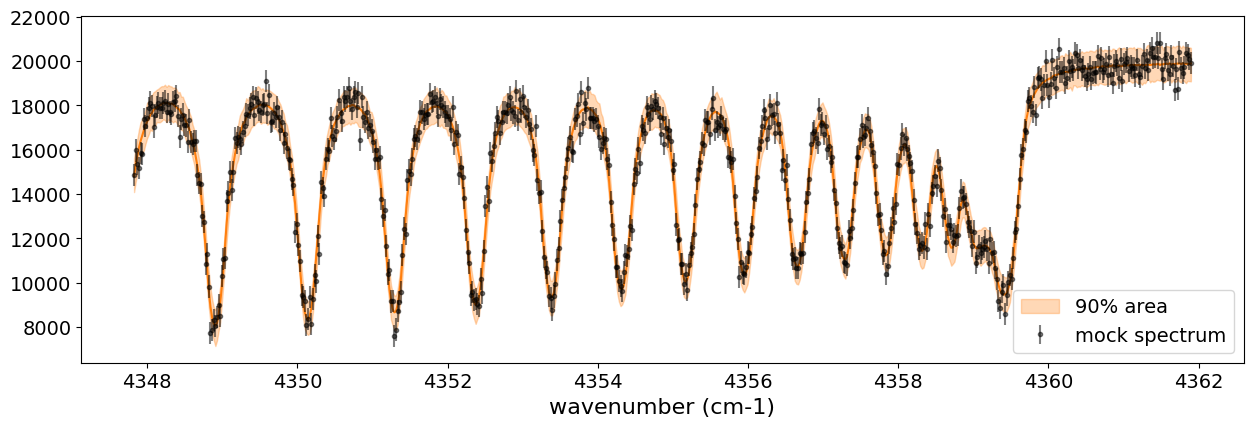

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(nu_obs, median_mu1, color='C1')
ax.fill_between(nu_obs,
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(nu_obs, Fobs, noise, fmt=".", label="mock spectrum", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

You can see that the predictions are working very well! Let’s also display a corner plot. Here, we’ve used ArviZ for visualization.

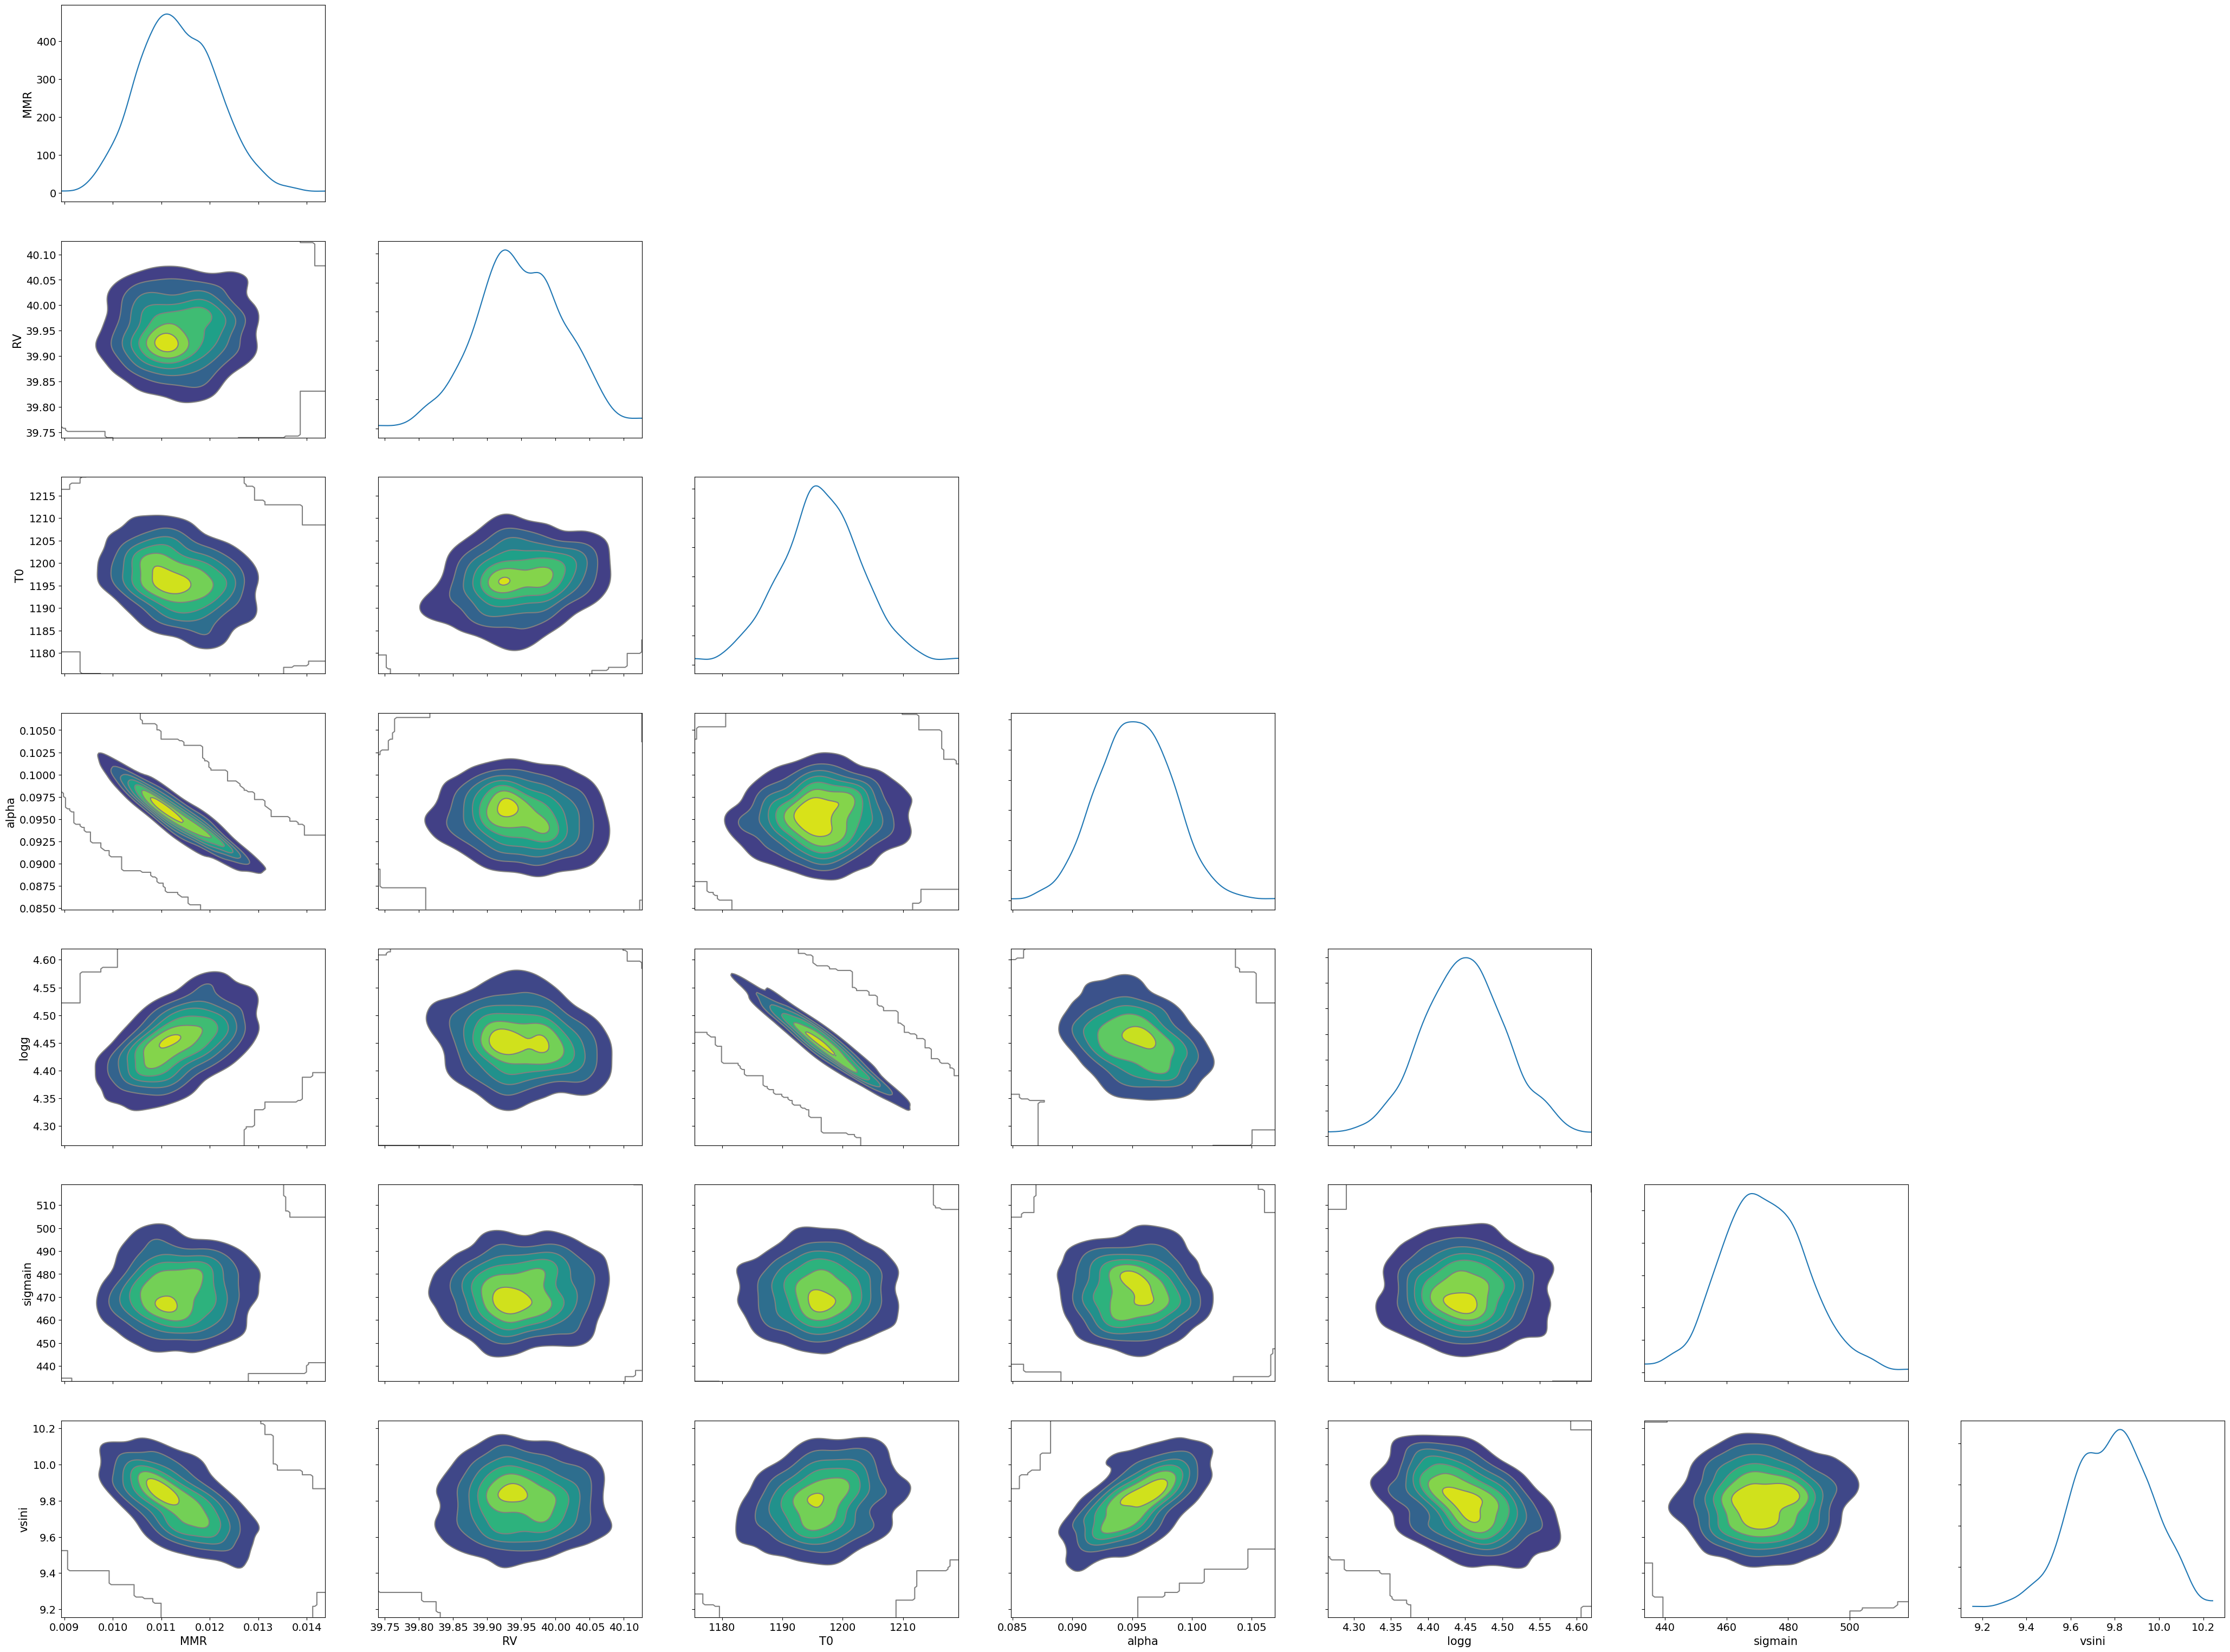

In [100]:
import arviz
pararr = ['T0', 'alpha', 'logg', 'MMR', 'vsini', 'RV']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=False,
                marginals=True)
plt.show()

The correlation between `T0` and `alpha` arises because both are parameters of the temperature model. The degeneracy between MMR and `logg` occurs because, in the case of molecular absorption alone, opacity depends only on the ratio $\text{MMR}/g$, leading to complete degeneracy. However, the presence of CIA breaks this degeneracy. For more details, please refer to [Kawashima et al.](https://arxiv.org/abs/2410.11561)

## 6. Modeling correlated noise with a Gaussian Process


In actual spectra, in addition to uncorrelated noise such as shot noise, correlated noise often exists due to various factors. For this case, let’s consider using a Gaussian Process (GP) as the probabilistic model for analysis. Here, we will employ a probabilistic model that assumes the noise distribution of the observed spectrum follows a multivariate Gaussian distribution. 

A multivariate Gaussian distribution is defined by its mean and covariance matrix, $\Sigma$. While the mean is provided by the spectral model, the challenge lies in how to model the covariance matrix. 

${\bf f}({\boldsymbol{\nu}}) \sim \mathcal{N}(\mu({\boldsymbol{\nu}}; {\bf p}), \Sigma)$

In this case, we consider noise where closer wavenumbers exhibit stronger correlations. For example, the covariance matrix can be modeled using an RBF kernel, which takes the distance between wavenumbers as a variable. In this approach, the correlation length and amplitude become the parameters of the probabilistic model. 

However, since uncorrelated noise may also be present, a diagonal term is added to the covariance matrix. The intensity of the uncorrelated noise is expressed as $\sigma^2$. Written mathematically, the covariance matrix is as follows. 

$k(\nu_i-\nu_j; a, \tau, \sigma) = a \exp{\left[- \frac{(\nu_i - \nu_j)^2}{2 \tau^2} \right]} + \sigma^2 \delta_{ij}$

Although ExoJAX version 2 and later provide built-in functions for GPs, we will explicitly define the functions here for clarity.

In [103]:
# from exojax.utils.gpkernel import gpkernel_RBF

def gpkernel_RBF(x, scale, amplitude, err):
    """RBF kernel with diagnoal error.

    Args:
        x (array): variable vector (N)
        scale (float): scale parameter
        amplitude (float) : amplitude (scalar)
        err (1D array): diagnonal error vector (N)

    Returns:
        kernel
    """

    diff = x - jnp.array([x]).T
    return amplitude * jnp.exp(-((diff) ** 2) / 2 / (scale**2)) + jnp.diag(err**2)

Now, let’s generate correlated noise using a GP with an RBF kernel. By sampling from `dist.MultivariateNormal` with zero mean and the covariance matrix generated from the kernel, we can create correlated noise alone (top panel in the figure below). Similarly, by using the spectral model as the mean and sampling from `dist.MultivariateNormal` with the covariance matrix generated from the kernel, we can generate a mock spectrum with correlated noise included (bottom panel).

Note that we constructed the GP in wavenumber space, but depending on the instrument specifications, it might be more appropriate to model it in wavelength space.

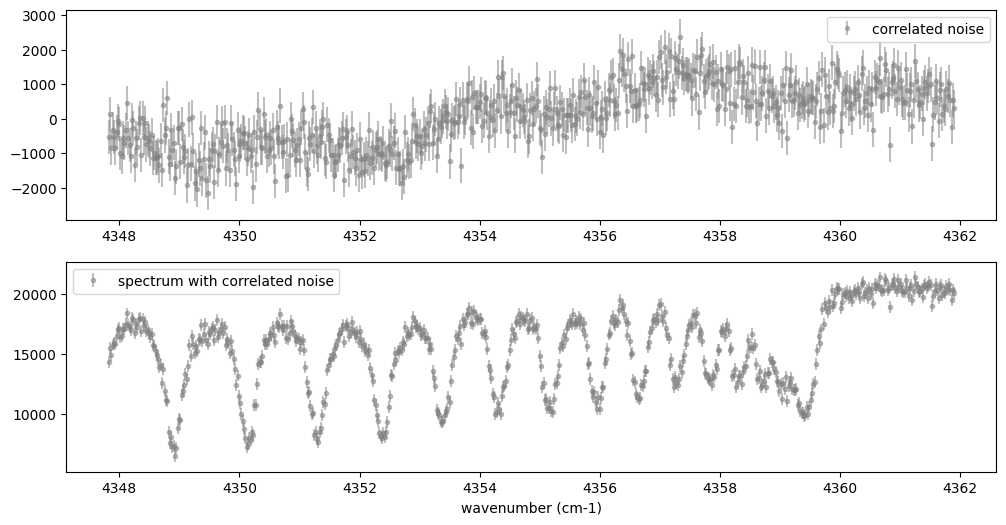

In [123]:
# correltaed noise only
cov = gpkernel_RBF(nu_obs, 1.0, 500**2, noise*jnp.ones_like(nu_obs))
noise_model = dist.MultivariateNormal(loc=jnp.zeros_like(nu_obs), covariance_matrix=cov)
correlated_noise = numpyro.sample("correlated_noise", noise_model, rng_key=random.PRNGKey(20))

# spectrum model with the correlated noise
spec_noise_model = dist.MultivariateNormal(loc=sop_inst.sampling(Finst, RV, nu_obs), covariance_matrix=cov)
Fobs_cn = numpyro.sample("speccn", spec_noise_model, rng_key=random.PRNGKey(20))

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
plt.errorbar(nu_obs, correlated_noise, noise, fmt=".", label="correlated noise", color="gray",alpha=0.5)
plt.legend()
ax = fig.add_subplot(212)
plt.errorbar(nu_obs, Fobs_cn, noise, fmt=".", label="spectrum with correlated noise", color="gray",alpha=0.5)
plt.xlabel("wavenumber (cm-1)")
plt.legend()
plt.show()

Let’s perform a retrieval on this mock spectrum with correlated noise.

In [128]:
def model_prob_gp(spectrum):

    # atmospheric/spectral model parameters priors
    logg = numpyro.sample("logg", dist.Uniform(4.0, 5.0))
    RV = numpyro.sample("RV", dist.Uniform(35.0, 45.0))
    mmr = numpyro.sample("MMR", dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample("T0", dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample("alpha", dist.Uniform(0.05, 0.2))
    vsini = numpyro.sample("vsini", dist.Uniform(5.0, 15.0))
    mu = fspec(T0, alpha, mmr, 10**logg, RV, vsini)

    # GP
    tau = numpyro.sample("tau", dist.LogUniform(0.1, 10.0))  # tau=1 <=> 1cm-1
    a = numpyro.sample("a", dist.LogUniform(1.e4, 1.e8))  # 100-10000

    # noise model parameters priors
    sigmain = numpyro.sample("sigmain", dist.Exponential(1.0e-3))
    cov = gpkernel_RBF(nu_obs, tau, a, sigmain*jnp.ones_like(nu_obs))

    numpyro.sample(
        "spectrum", dist.MultivariateNormal(loc=mu, covariance_matrix=cov), obs=spectrum
    )

In [129]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_prob, forward_mode_differentiation=True)
kernel = NUTS(model_prob_gp, forward_mode_differentiation=False)

In [ ]:
mcmc_gp = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc_gp.run(rng_key_, spectrum=Fobs_cn)
mcmc_gp.print_summary()

sample: 100%|██████████| 1500/1500 [2:07:48<00:00,  5.11s/it, 63 steps of size 5.27e-02. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       MMR      0.01      0.00      0.01      0.01      0.01    322.95      1.00
        RV     39.98      0.07     39.98     39.85     40.09    606.25      1.00
        T0   1206.44     16.22   1205.89   1181.20   1233.32    369.54      1.00
     alpha      0.09      0.01      0.09      0.08      0.11    383.62      1.00
      loga      5.80      0.24      5.78      5.41      6.13    500.14      1.00
      logg      4.38      0.15      4.38      4.12      4.59    338.18      1.00
    logtau      0.10      0.05      0.10      0.01      0.18    553.31      1.00
   sigmain    493.56     13.30    493.22    470.74    514.01   1024.11      1.00
     vsini     10.02      0.20     10.02      9.66     10.32    445.02      1.00

Number of divergences: 0


Below, we display the credible interval calculated using `Predictive`, as done earlier. In this case, it appears that the interval does not adequately encompass the data. This is because the GP itself is being sampled as part of the error, meaning it does not represent a realization consistent with the given data.

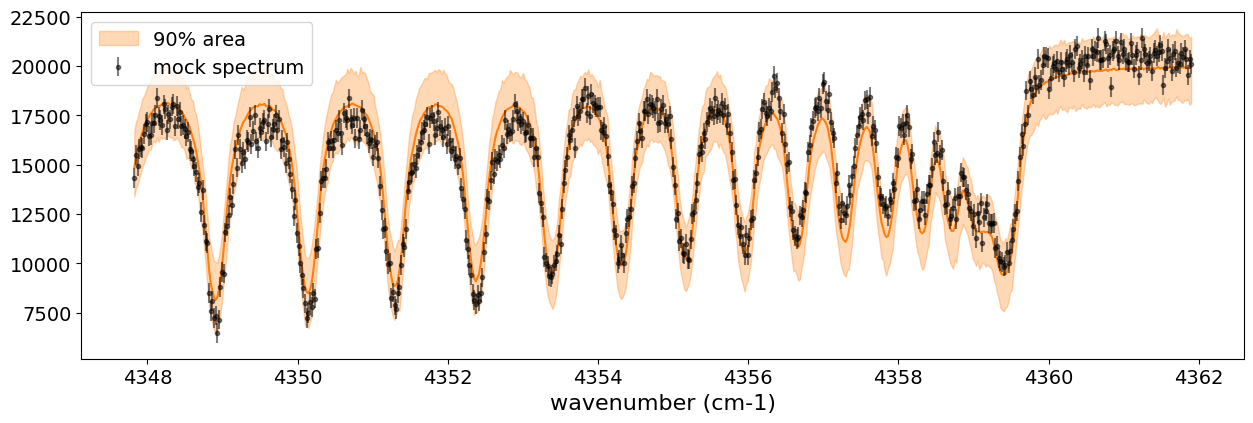

In [133]:
# SAMPLING
posterior_sample_gp = mcmc_gp.get_samples()
pred_gp = Predictive(model_prob_gp, posterior_sample_gp, return_sites=['spectrum'])
predictions_gp = pred_gp(rng_key_, spectrum=None)
median_mu2 = jnp.median(predictions_gp['spectrum'], axis=0)
hpdi_mu2 = hpdi(predictions_gp['spectrum'], 0.9)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(nu_obs, median_mu2, color='C1')
ax.fill_between(nu_obs,
                hpdi_mu2[0],
                hpdi_mu2[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(nu_obs, Fobs_cn, noise, fmt=".", label="mock spectrum", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

Therefore, we perform sampling with the GP as the model. The mean and covariance of the GP as a model can be calculated as follows. For details on these equations, refer to Appendix F of [Paper I](https://arxiv.org/abs/2105.14782) or [this memo](https://secondearths.sakura.ne.jp/exojax/jaxgp.pdf) created by one of the authors (H.K.). From ExoJAX version 2 onward, this function is included in `utils.gpkernel`.

In [228]:
#from exojax.utils.gpkernel import average_covariance_gpmodel # available later than version 2.0

from jax import jit
@jit
def average_covariance_gpmodel(x, data, model, scale, amplitude, err):
    """computes average and covariance of GP model
    
    Args:
        x (array): variable vector (N)
        data (array): data vector (N)
        scale (float): scale parameter
        amplitude (float) : amplitude (scalar)
        err (1D array): diagnonal error vector (N)

    Returns:
        _type_: average, covariance
    """
    cov = gpkernel_RBF(x, scale, amplitude, err)
    covx = gpkernel_RBF(x, scale, amplitude, jnp.zeros_like(x))
    A = jnp.linalg.solve(cov, data - model)
    IKw = jnp.linalg.inv(cov)
    return model + covx @ A, cov - covx @ IKw @ covx.T



Next, for each GP hyperparameter (scale, amplitude, diagonal components) sampled by HMC, we calculate the mean and covariance of the GP model. From these, we resample the predictions using `MultivariateNormal`. In this way, we can compute predictions based on the GP model for a specified number of samples (`num_samples`).

In [231]:
import tqdm
scale_sampling = posterior_sample_gp["tau"]
amplitude_sampling = posterior_sample_gp["a"]
err_sampling = jnp.array(posterior_sample_gp["sigmain"])[:,None]*jnp.ones((num_samples, len(nu_obs)))
prediction_spectrum = predictions_gp["spectrum"]
key = random.PRNGKey(20)

#from exojax.utils.gpkernel import sampling_prediction # available later than version 2.0
def sampling_prediction(
    x,
    data,
    scale_sampling,
    amplitude_sampling,
    err_sampling,
    prediction_spectrum,
    key,
):
    num_samples = len(scale_sampling)
    gp_predictions = []
    for i in tqdm.tqdm(range(0, num_samples)):
        ave, cov = average_covariance_gpmodel(
            x,
            data,
            prediction_spectrum[i],
            scale_sampling[i],
            amplitude_sampling[i],
            err_sampling[i],
        )
        mn = dist.MultivariateNormal(loc=ave, covariance_matrix=cov)
        key, _ = random.split(key)
        mk = numpyro.sample("mk", mn, rng_key=key)

        gp_predictions.append(mk)
    return jnp.array(gp_predictions)


gp_predictions = sampling_prediction(
    nu_obs,
    Fobs_cn,
    scale_sampling,
    amplitude_sampling,
    err_sampling,
    prediction_spectrum,
    key,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:16<00:00, 60.09it/s]


All that remains is to calculate the median and HPDI and plot them as before.

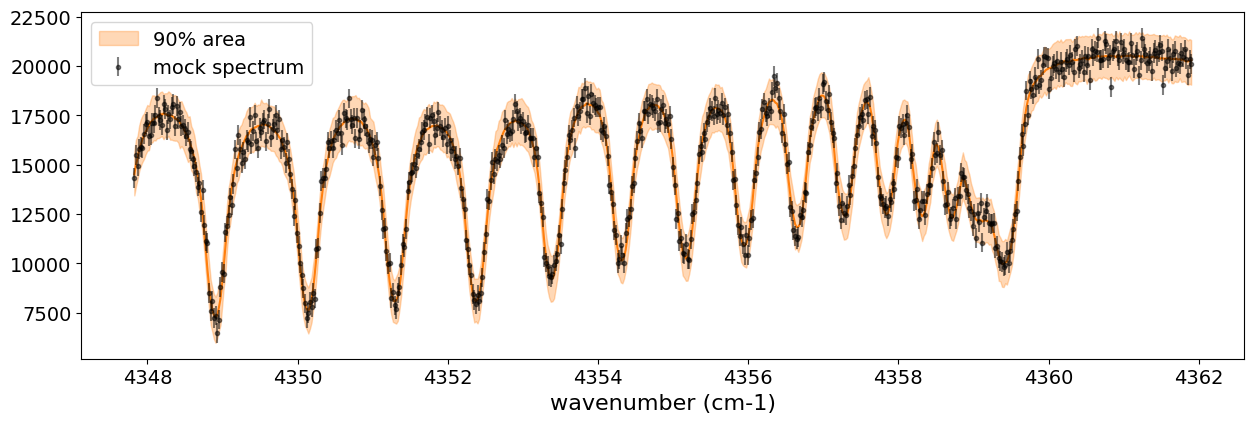

In [232]:
median_muys = jnp.median(gp_predictions, axis=0)
hpdi_muys = hpdi(gp_predictions, 0.9)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4.5))
ax.plot(nu_obs, median_muys, color='C1')
ax.fill_between(nu_obs,
                hpdi_muys[0],
                hpdi_muys[1],
                alpha=0.3,
                interpolate=True,
                color='C1',
                label='90% area')
ax.errorbar(nu_obs, Fobs_cn, noise, fmt=".", label="mock spectrum", color="black",alpha=0.5)
plt.xlabel('wavenumber (cm-1)', fontsize=16)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

The essential advantage of using the GP model lies in its ability to account for correlated noise when calculating the posterior distribution (not in the apparent reduction of residuals with the data, so be mindful of this!). Let’s create a corner plot to verify the results.

Text(0, 0.5, 'MMR')

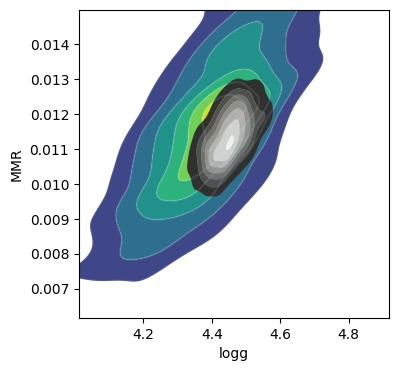

In [270]:
plt.figure(figsize=(4, 4))
ax = arviz.plot_kde(
    posterior_sample_gp["logg"],
    values2=posterior_sample_gp["MMR"],
    contourf_kwargs={"cmap": "viridis"},
    contour_kwargs={"colors": "white","alpha":0.1},
)
ax2 = arviz.plot_kde(
    posterior_sample["logg"],
    values2=posterior_sample["MMR"],
    contourf_kwargs={"cmap": "gray"},
    contour_kwargs={"colors": "white","alpha":0},
)
ax.set_xlabel("logg")
ax.set_ylabel("MMR")

That's it!